In [1]:
import scipy.io
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.signal import find_peaks, peak_widths

In [2]:
def LoadDataFrame(filename):
    #loading .mat files for each measurement
    dotmat = scipy.io.loadmat(filename)
    
    #selecting timetags and channels for each measurement
    timetag = dotmat['data'][0][0][0][0]
    channel = dotmat['data'][0][0][1][0]
    
    #building dataframe out of timetags and channels for each measurement 
    df = pd.DataFrame({'timetag':timetag, 'channel':channel})
    
    return df

def FindCoincidences(df):
    
    ch=df['channel'].to_numpy()
    tt=df['timetag'].to_numpy()

    ok_data = []
    
    for ii in tqdm(range(len(ch)-1)):

        if ch[ii]==2:
            if ch[ii+1]!=2:
                ok_data.append(np.array([tt[ii+1]-tt[ii],ch[ii+1]]))
                        
    ok_data = np.array(ok_data)
    ok_td = ok_data[:,0]
    ok_ch = ok_data[:,1]
        
    return pd.DataFrame({'time_diff':ok_td, 'ch':ok_ch})

def FilterNoise(df, df_name):
    df_aux3 = df[df['ch']==3]
    n3, bins3, patches3 = plt.hist(df_aux3['time_diff'], bins = 51, range=(0,10000), 
                                   alpha=.4, label = 'Transmitted')
    center_bins3 = (bins3[:-1] + bins3[1:]) / 2
    peak = find_peaks(n3,width=3,height=0.5*max(n3))
    window = [center_bins3[peak[1]['left_bases']][0],center_bins3[peak[1]['right_bases']][0]]
    if len(window) > 2: print('Multiple peaks detected on channel 3')
    else: df_aux3 = df_aux3[(df_aux3['time_diff']>window[0]) & (df_aux3['time_diff']<window[1])]
        
    df_aux4 = df[df['ch']==4]
    n4, bins4, patches4 = plt.hist(df_aux4['time_diff'], bins = 51, range=(0,10000), 
                                   alpha=.4, label = 'Reflected')
    center_bins4 = (bins4[:-1] + bins4[1:]) / 2
    peak = find_peaks(n4,width=3,height=0.5*max(n4))
    window = [center_bins4[peak[1]['left_bases']][0],center_bins4[peak[1]['right_bases']][0]]
    if len(window) > 2: print('Multiple peaks detected on channel 4')
    else: df_aux4 = df_aux4[(df_aux4['time_diff']>window[0]) & (df_aux4['time_diff']<window[1])]
        
        
    plt.legend()
    plt.title('Valid events ' + df_name)
    plt.xlabel('Retard wrt heralded photon')
    plt.ylabel('Counts')
    #plt.show()
    return pd.concat([df_aux3,df_aux4])

filename = 'Data/Raw_data/d_state_measured_on_hv_basis.mat'
d_state_HV = LoadDataFrame(filename)
d_state_HV = FindCoincidences(d_state_HV)

filename = 'Data/Raw_data/d_state_measured_on_da_basis.mat'
d_state_DA = LoadDataFrame(filename)
d_state_DA = FindCoincidences(d_state_DA)

filename = 'Data/Raw_data/mixed_state_measured_on_da_basis.mat'
mixed_state_DA = LoadDataFrame(filename)
mixed_state_DA = FindCoincidences(mixed_state_DA)

filename = 'Data/Raw_data/mixed_state_measured_on_hv_basis.mat'
mixed_state_HV = LoadDataFrame(filename)
mixed_state_HV = FindCoincidences(mixed_state_HV)

filename = 'Data/Raw_data/l_state_measured_on_hv_basis.mat'
l_state_HV = LoadDataFrame(filename)
l_state_HV = FindCoincidences(l_state_HV)

filename = 'Data/Raw_data/l_state_measured_on_da_basis.mat'
l_state_DA = LoadDataFrame(filename)
l_state_DA = FindCoincidences(l_state_DA)

filename = 'Data/Raw_data/l_state_measured_on_lr_basis.mat'
l_state_LR = LoadDataFrame(filename)
l_state_LR = FindCoincidences(l_state_LR)

df_names = ['d_state_HV','d_state_DA','mixed_state_DA','mixed_state_HV','l_state_HV','l_state_DA','l_state_LR']
df_all = [d_state_HV,d_state_DA,mixed_state_DA,mixed_state_HV,l_state_HV,l_state_DA,l_state_LR]

for n in range(len(df_names)):
    df_all[n].to_csv('Data/Filtered_data/'+df_names[n]+'.csv')

In [3]:
d_state_HV =  
d_state_DA = pd.read_csv('/Users/ale/QuantumCryptoBusiness/Data/Filtered_data/d_state_DA.csv',usecols=[1, 2])
mixed_state_DA = pd.read_csv('/Users/ale/QuantumCryptoBusiness/Data/Filtered_data/mixed_state_DA.csv',usecols=[1, 2])
mixed_state_HV = pd.read_csv('/Users/ale/QuantumCryptoBusiness/Data/Filtered_data/mixed_state_HV.csv',usecols=[1, 2])
l_state_HV = pd.read_csv('/Users/ale/QuantumCryptoBusiness/Data/Filtered_data/l_state_HV.csv',usecols=[1, 2])
l_state_DA = pd.read_csv('/Users/ale/QuantumCryptoBusiness/Data/Filtered_data/l_state_DA.csv',usecols=[1, 2])
l_state_LR = pd.read_csv('/Users/ale/QuantumCryptoBusiness/Data/Filtered_data/l_state_LR.csv',usecols=[1, 2])

In [4]:
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, _ = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

def gauss_err(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    _, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return np.sqrt(np.diag(pcov))

In [ ]:
def FilterNoise(window,data):
    time_min = window[0]
    time_max = window[1]
    data = data[(data['time']>time_min) & (data['time']<time_max)]
    return data

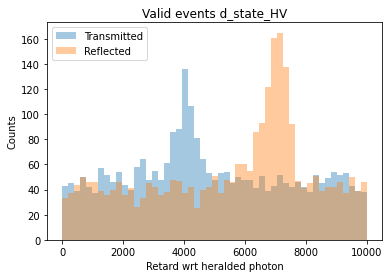

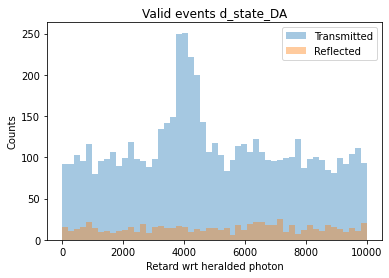

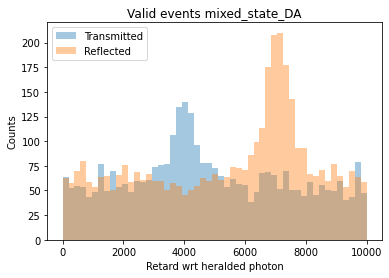

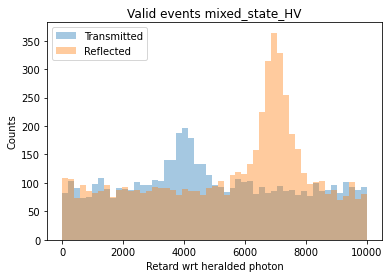

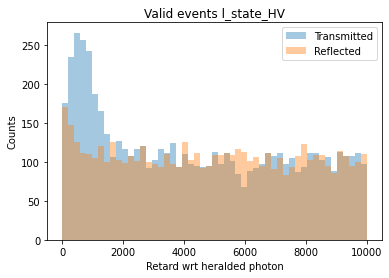

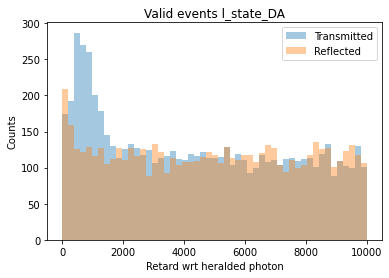

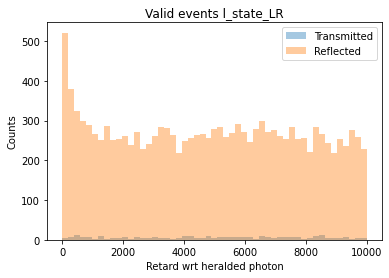

In [258]:
df_names = ['d_state_HV','d_state_DA','mixed_state_DA','mixed_state_HV','l_state_HV','l_state_DA','l_state_LR'] 
df_all = [d_state_HV,d_state_DA,mixed_state_DA,mixed_state_HV,l_state_HV,l_state_DA,l_state_LR]

for n in range(len(df_names)): 
    df_all[n] = FilterNoise(df_all[n],df_names[n])

In [179]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))/(sig*np.sqrt(2*np.pi))

def f(x, mu, sig, c, d):
    return gaussian(x,mu,sig) + c*x + d
    

In [180]:
# Perform fit for hermitian eigenvals
print(center_bins3,n3)
center_bins3 = (bins3[:-1] + bins3[1:]) / 2
popt3, pcov3 = curve_fit(f, center_bins3, n3, p0=[7000,500,0,25])

print('fit: H=%5.3f, A=%5.3f, x0=%5.3f, sig=%5.3f' % tuple(result_params))

[  98.03921569  294.11764706  490.19607843  686.2745098   882.35294118
 1078.43137255 1274.50980392 1470.58823529 1666.66666667 1862.74509804
 2058.82352941 2254.90196078 2450.98039216 2647.05882353 2843.1372549
 3039.21568627 3235.29411765 3431.37254902 3627.45098039 3823.52941176
 4019.60784314 4215.68627451 4411.76470588 4607.84313725 4803.92156863
 5000.         5196.07843137 5392.15686275 5588.23529412 5784.31372549
 5980.39215686 6176.47058824 6372.54901961 6568.62745098 6764.70588235
 6960.78431373 7156.8627451  7352.94117647 7549.01960784 7745.09803922
 7941.17647059 8137.25490196 8333.33333333 8529.41176471 8725.49019608
 8921.56862745 9117.64705882 9313.7254902  9509.80392157 9705.88235294
 9901.96078431] [ 33.  37.  44.  50.  46.  46.  39.  36.  40.  46.  36.  41.  26.  33.
  45.  42.  36.  38.  48.  47.  37.  42.  25.  40.  42.  51.  37.  48.
  46.  60.  60.  55.  86.  93. 122. 161. 165. 138.  92.  47.  41.  45.
  51.  39.  42.  42.  46.  37.  50.  39.  46.]
fit: mu=370057.

/usr/local/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


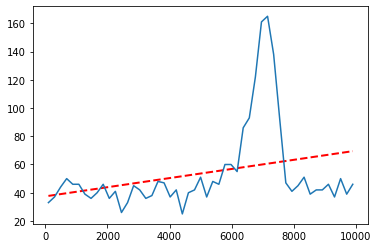

In [181]:
plt.plot(center_bins3, f(center_bins3, *popt3), color='r', lw=2, ls='--')
plt.plot(center_bins3,n3)
#plt.hist(df_aux['time_diff'], bins = 101, range=(0,10000), density=True)
plt.show()

In [182]:
def FindEvents(df):
    
    ii = 0
    tag = 0

    ch=df['channel'].to_numpy()
    tt=df['timetag'].to_numpy()
    
    n = len(ch)

    final_tt = np.zeros(n)
    
    for ii in tqdm(range(len(ch))):

        if(ch[ii]==2):
            tag += 1
            jj = ii+1
            final_tt[ii] = tag
            while(jj != n and ch[jj] != 2):
                final_tt[jj] = tag
                jj += 1
            ii = jj
        ii += 1
        
    return pd.DataFrame({'tt':tt, 'ch':ch, 'tag':final_tt})


In [183]:
df = FindEvents(d_state_HV)

100%|██████████| 17139593/17139593 [01:05<00:00, 260994.35it/s]


In [191]:
%%time
df2 = df.groupby('tag').filter(lambda x : len(x) > 1)

CPU times: user 3min 17s, sys: 2.91 s, total: 3min 20s
Wall time: 3min 21s


In [206]:
def myfunc(df_red, window):
    if len(df_red) == 2:
        return df_red[df_red['ch']!=2]
    if len(df_red) > 2:
        time = min(df_red['tt'])
        df_aux = df_red[(df_red['ch']!=2) & (df_red['tt'] - time < window)]
        if len(df_aux) == 1:
            return df_aux 

In [207]:
%%time
df2 = df.groupby('tag').apply(lambda x : myfunc(x,5000))

KeyboardInterrupt: 

In [195]:
df = df[df.duplicated(subset=['tag'], keep=False)]

In [208]:
df

,tt,ch,tag
0,12161102376312681,2,1.0
1,12161102392943325,3,1.0
4,12161102407436280,2,4.0
5,12161102423808110,4,4.0
8,12161102436221351,2,7.0
...,...,...,...
17139587,12314688495916298,4,6337386.0
17139588,12314688510017132,3,6337386.0
17139589,12314688529283371,2,6337387.0
17139590,12314688530123125,4,6337387.0


In [212]:
df_len = df.groupby('tag').size()

In [218]:
print('tot:',len(df_len))
print('2:',len(df_len[df_len==2]))
print('3:',len(df_len[df_len==3]))
print('4+:',len(df_len[df_len>3]))

tot: 3946435
2: 1453681
3: 914895
4+: 1577859


In [222]:
def FindEvents(df, window):
    
    ch=df['channel'].to_numpy()
    tt=df['timetag'].to_numpy()

    ok_data = []
    
    for ii in tqdm(range(len(ch))):

        if ch[ii]!=2:
            if ch[ii-1]==2:
                if tt[ii]-tt[ii-1] < window:
                    if tt[ii+1]-tt[ii-1] >= window:
                        ok_data.append(np.array([tt[ii],ch[ii]]))
                        
    ok_data = np.array(ok_data)
    ok_tt = ok_data[:,0]
    ok_ch = ok_data[:,1]
        
    return pd.DataFrame({'tt':ok_tt, 'ch':ok_ch})

In [223]:
df2 = FindEvents(d_state_HV,5000)

100%|██████████| 17139593/17139593 [00:50<00:00, 340460.89it/s]


In [224]:
df2

,tt,ch
0,12161200850620496,3
1,12161203053130290,4
2,12161227934683998,4
3,12161294741612346,3
4,12161307627631686,3
...,...,...
2537,12314477889375145,4
2538,12314489514323682,3
2539,12314514289003882,4
2540,12314608655937178,4


In [225]:
d_state_HV

,timetag,channel
0,12161102376312681,2
1,12161102392943325,3
2,12161102395760037,2
3,12161102402303245,2
4,12161102407436280,2
...,...,...
17139588,12314688510017132,3
17139589,12314688529283371,2
17139590,12314688530123125,4
17139591,12314688552871337,4


In [120]:
def FindCoincidences(df, window):
    diff1 = df['timetag'].diff(periods = 1)
    diff2 = df['timetag'].diff(periods = 2).shift(-1)
    display(diff1)
    display(diff2)
    mask = (diff1 < window) & (diff2 >= window) & (df['channel']!=2)
    masked_idx = df.index[mask]
    print(masked_idx)
    return df[masked_idx]

In [156]:
def FindCoincidences(df, window):
    data = []
    for idx in tqdm(df[df['channel']==2].index):
        time = df.loc[idx]['timetag']
        df_aux = df[(df['timetag']<time+window) & (df['timetag']>time-window)]
        df_aux = df_aux[df_aux['channel']!=2]
        if len(df_aux==1):
            mydict = {
                'timetag' : int(df_aux['timetag']),
                'channel' : int(df_aux['channel'])
            }
            data.append(mydict)
    return data

In [157]:
filename = 'Data/d_state_measured_on_hv_basis.mat'
d_state_HV = LoadDataFrame(filename)

FindCoincidences(d_state_HV, 5000)

  0%|          | 1427/6337388 [01:05<81:00:29, 21.73it/s]


KeyboardInterrupt: 

In [100]:
d_state_HV = d_state_HV[1:1000]

In [169]:
d_state_HV[0:10]

,timetag,channel
1,12161102392943325,3
2,12161102395760037,2
3,12161102402303245,2
4,12161102407436280,2
5,12161102423808110,4
6,12161102432960779,2
7,12161102433564107,2
8,12161102436221351,2
9,12161102439164202,4
10,12161102439168494,2


In [160]:
filename = 'Data/d_state_measured_on_hv_basis.mat'
d_state_HV = LoadDataFrame(filename)[1:10000]

In [170]:
print ((d_state_HV.channel != 2).cumsum())[0:10]

1          1
2          1
3          1
4          1
5          2
        ... 
9995    6315
9996    6315
9997    6316
9998    6317
9999    6318
Name: channel, Length: 9999, dtype: int64


TypeError: 'NoneType' object is not subscriptable

In [ ]:
window = 5000 #ps

df['valid'] = False
    for idx in df[df['channel'] == 2].index:
        if (df.loc[idx,'timetag'] - df.loc[idx+1,'timetag'] < window) and (df.loc[idx,'timetag'] - df.loc[idx,'timetag'] < window):
            df.loc[idx+1,'valid']